In [1]:
# License: BSD
# Authors: A. Anders Larson Tevis, Ben Lloyd, Caleb Flaim, Jackson R. Page-Roth
# Built using existing code from: Sasank Chilamkurthy's "Transfer learning for computer vision tutorial"
# ChatGPT used to manipulate basic code structures and to help resolve errors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import re
from torch.utils.data import Dataset, DataLoader
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Comment in the correct class name for your model (subfamily, tribe, or genus) in the 'extract_class_name' function

# Regular expression function to extract class names
def extract_class_name(file_path):
    # match = re.match(r'^([^_]+)_', file_path) # Use this for subfamily
    match = re.match(r'^[^_]+_([^_]+)_', file_path) # Use this for tribe
    # match = re.match(r'^[^_]+_[^_]+_([^_]+)_', file_path) # Use this for genus
    if match:
        return match.group(1)
    else:
        return None

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_names, class_to_index, transform=None):
        self.file_names = file_names
        self.class_to_index = class_to_index
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        class_name = extract_class_name(file_name)
        class_index = self.class_to_index[class_name]

        image_path = os.path.join(data_dir, file_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, class_index

# Data directory
data_dir = 'Modern_Grasses_jpg'

# List all file names in the directory
file_names = os.listdir(data_dir)
# file_names = file_names[0:len(file_names):40] # Comment in to limit number of pictures fed into model

# Extract unique class names using regular expressions and convert to strings
unique_class_names = set(extract_class_name(file_name) for file_name in file_names)
class_names = list(map(str, unique_class_names))

# Create a mapping from class name to index
class_to_index = {class_name: i for i, class_name in enumerate(class_names)}

# Randomly shuffle the file names
random.shuffle(file_names)

# Split the data into train and val sets (80% train, 20% val)
split_index = int(0.8 * len(file_names))
train_file_names = file_names[:split_index]
val_file_names = file_names[split_index:]

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and data loaders for train and val
image_datasets = {
    'train': CustomDataset(train_file_names, class_to_index, transform=data_transforms['train']),
    'val': CustomDataset(val_file_names, class_to_index, transform=data_transforms['val']),
}

# Create data loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=4, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Class Names:", class_names)

Class Names: ['Streptogyneae', 'Guaduellieae', 'Danthonieae', 'Gynerieae', 'Micraireae', 'Paspaleae', 'Zeugiteae', 'Brachyelytreae', 'Cynodonteae', 'Andropogoneae', 'Anomochloeae', 'Molinieae', 'Paniceae', 'Centropodieae', 'Olyreae', 'Arundinarieae', 'Lygeae-Nardeae', 'Phyllorachideae', 'Streptochaeteae', 'Eriachneae', 'Eragrostideae', 'Poeae', 'Stipeae', 'Atractocarpeae', 'Ehrharteae', 'Arundineae', 'Zoysieae', 'Oryzeae', 'Phareae', 'paspaleae', 'Bambuseae', 'Bromeae', 'Isachneae', 'Aristideae']


/home/tevisaa/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


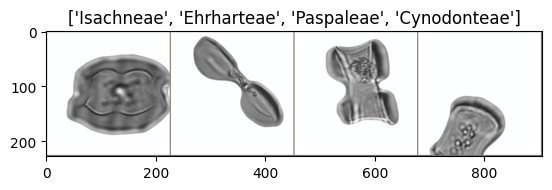

In [3]:
# Function to display images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Convert class_names to a list before passing it to imshow
class_names_list = list(class_names)
imshow(out, title=[class_names_list[x] for x in classes])

In [4]:
# Function to plot loss and accuracy
def plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy, save_path, dpi=300):
    epochs = len(train_loss)

    # Find the maximum values in both training and validation datasets
    max_loss = max(max(train_loss), max(val_loss))
    buffer = 0.5  # Buffer value to add above the maximum loss

    # Calculate the new maximum loss value with the buffer
    new_max_loss = max_loss + buffer

    max_accuracy = 1.0  # Set maximum accuracy to 1 for both 'train' and 'val' plots

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for the 'train' dataset
    color_loss_train = 'tab:red'
    color_accuracy_train = 'tab:blue'

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss_train)
    line1, = ax1.plot(np.arange(1, epochs+1), train_loss, color=color_loss_train, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss_train)
    ax1.set_ylim(0, new_max_loss)  # Set y-axis limit for loss with the buffer

    ax1_2 = ax1.twinx()
    ax1_2.set_ylabel('Accuracy', color=color_accuracy_train)
    line2, = ax1_2.plot(np.arange(1, epochs+1), train_accuracy, color=color_accuracy_train, label='Accuracy')
    ax1_2.tick_params(axis='y', labelcolor=color_accuracy_train)
    ax1_2.set_ylim(0, max_accuracy)  # Set y-axis limit for accuracy from 0 to 1

    legend1 = ax1.legend(handles=[line1, line2], loc='upper left')
    ax1.set_title('Training Dataset')

    # Plot for the 'val' dataset
    color_loss_val = 'tab:red'
    color_accuracy_val = 'tab:blue'

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss', color=color_loss_val)
    line3, = ax2.plot(np.arange(1, epochs+1), val_loss, color=color_loss_val, label='Loss')
    ax2.tick_params(axis='y', labelcolor=color_loss_val)
    ax2.set_ylim(0, new_max_loss)  # Set y-axis limit for loss with the buffer

    ax2_2 = ax2.twinx()
    ax2_2.set_ylabel('Accuracy', color=color_accuracy_val)
    line4, = ax2_2.plot(np.arange(1, epochs+1), val_accuracy, color=color_accuracy_val, label='Accuracy')
    ax2_2.tick_params(axis='y', labelcolor=color_accuracy_val)
    ax2_2.set_ylim(0, max_accuracy)  # Set y-axis limit for accuracy from 0 to 1

    legend2 = ax2.legend(handles=[line3, line4], loc='upper left')
    ax2.set_title('Testing Dataset')

    # Create a legend box for each subplot
    ax1.add_artist(legend1)
    ax2.add_artist(legend2)

    fig.tight_layout()
    plt.savefig(save_path, dpi=dpi)
    plt.show()

# Function to plot histogram of accuracy for each class in the final epoch
def plot_class_accuracy_histogram(class_accuracies, class_names, save_path, bar_color='turquoise', bar_outline_color='black', dpi=300):
    plt.figure(figsize=(15, 7))

    final_epoch_accuracies = []

    for class_idx in range(len(class_names)):
        class_acc = [acc[class_idx] for acc in class_accuracies if class_idx in acc]
        final_epoch_accuracies.append(np.mean(list(class_acc)) if class_acc else 0)

    # Modify the plt.bar function to set color and outline color
    plt.bar(class_names, final_epoch_accuracies, color='turquoise', edgecolor='black')

    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Tribe Accuracy')
    plt.xticks(rotation='vertical', ha='center', fontsize=6)

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi)
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(labels, predictions, class_names, save_path, figsize=(12, 10), dpi=300):
    cm = confusion_matrix(labels, predictions, normalize='true')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation='vertical', ha='center', fontsize=6)
    plt.yticks(tick_marks, class_names, fontsize=6)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(save_path, dpi=dpi)
    plt.show()

def save_loss_accuracy_to_csv(train_losses, train_accuracies, val_losses, val_accuracies, save_path):
    # Convert tensors to Python numbers
    train_accuracies = [acc.item() for acc in train_accuracies]
    val_accuracies = [acc.item() for acc in val_accuracies]

    df = pd.DataFrame({
        'Epoch': list(range(1, len(train_losses) + 1)),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Val Loss': val_losses,
        'Val Accuracy': val_accuracies
    })

    df.to_csv(save_path, index=False)

# Function to save confidence of accuracy for image classification for each class for each epoch to CSV
def save_confidence_of_accuracy_to_csv(class_accuracies, save_path):
    df = pd.DataFrame(class_accuracies)
    df.index.name = 'Epoch'
    df.to_csv(save_path)

In [5]:
def train_model_with_outputs(model, criterion, optimizer, scheduler, num_epochs=25, save_dir='modelOutputTribe'):
    since = time.time()

    # Create the results directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # Lists to store outputs for each epoch
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        class_accuracies = []
        
        best_acc = 0.0  # Initialize best_acc here
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
        
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
        
                running_loss = 0.0
                running_corrects = 0
        
                # Lists to store predictions and ground truth labels for confusion matrix
                all_preds = []
                all_labels = []
        
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
        
                    # zero the parameter gradients
                    optimizer.zero_grad()
        
                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
        
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
        
                    # Append predictions and labels for confusion matrix
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
        
                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
                # Store outputs for plotting
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)
        
                    # Calculate and store class-wise accuracy for each epoch
                    class_labels = list(range(len(class_names)))
                    
                    # Handle the case where a class is not predicted during the epoch
                    conf_matrix = confusion_matrix(all_labels, all_preds, labels=class_labels)
                    class_counts = np.bincount(all_labels)
                    try:
                        class_acc = np.diag(conf_matrix) / np.where(class_counts == 0, 1, class_counts)
                    except ValueError as e:
                        print(f'Error calculating class accuracy: {e}')
                        class_acc = np.zeros(len(class_labels))
                    
                    class_accuracies.append(dict(zip(class_labels, class_acc)))
        
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        
            print()

        # Save results to the specified directory
        save_path = os.path.join(save_dir)
        os.makedirs(save_path, exist_ok=True)

        # Save loss and accuracy plots
        plot_path = os.path.join(save_path, 'loss_accuracy_plot.jpg')
        plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, plot_path)

        # Save histogram of accuracy for each class in the final epoch
        histogram_path = os.path.join(save_path, 'class_accuracy_histogram.jpg')
        plot_class_accuracy_histogram(class_accuracies, class_names, histogram_path)

        # Save confusion matrix as an image
        confusion_matrix_path = os.path.join(save_path, 'confusion_matrix.jpg')
        plot_confusion_matrix(all_labels, all_preds, class_names, confusion_matrix_path)

        # Save loss/accuracy statistics in a CSV file
        csv_path = os.path.join(save_path, 'loss_accuracy_statistics.csv')
        save_loss_accuracy_to_csv(train_losses, train_accuracies, val_losses, val_accuracies, csv_path)

        # Save confidence of accuracy for image classification for each class for each epoch in a CSV file
        confidence_csv_path = os.path.join(save_path, 'confidence_of_accuracy.csv')
        save_confidence_of_accuracy_to_csv(class_accuracies, confidence_csv_path)

        # Save the trained model
        model_save_path = os.path.join(save_path, 'trained_model.pt')
        torch.save(model.state_dict(), model_save_path)

    return model_save_path

In [6]:
# Function to visualize the output of a convolutional neural network
def visualize_model(model, num_images=6):
    # Save the current training mode of the model
    was_training = model.training
    # Set the model to evaluation mode
    model.eval()
    # Counter to keep track of the number of images processed
    images_so_far = 0
    # Create a new figure for plotting
    fig = plt.figure()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the validation dataset
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # Move inputs and labels to the appropriate device (e.g., GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = model(inputs)
            # Get the index of the maximum predicted value (class) for each image
            _, preds = torch.max(outputs, 1)

            # Iterate over each image in the batch
            for j in range(inputs.size()[0]):
                # Increment the count of processed images
                images_so_far += 1
                # Create a subplot for each image in the figure
                ax = plt.subplot(num_images//2, 2, images_so_far)
                # Turn off axis labels
                ax.axis('off')
                # Set the title of the subplot with the predicted class
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                # Display the image using a custom function (e.g., imshow)
                imshow(inputs.cpu().data[j])

                # Check if the desired number of images has been reached
                if images_so_far == num_images:
                    # Restore the original training mode of the model
                    model.train(mode=was_training)
                    # Exit the function
                    return
        # Restore the original training mode of the model if not enough images are available
        model.train(mode=was_training)

In [8]:
# Load the pre-trained ResNet-18 model with weights from ImageNet
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Update the number of features in the fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the specified device
model_ft = model_ft.to(device)

# Define the CrossEntropyLoss as the criterion for optimization
criterion = nn.CrossEntropyLoss()

# Set up the Stochastic Gradient Descent (SGD) optimizer
# to optimize all parameters in the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Set up learning rate (LR) scheduler to decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

Epoch 0/24
----------
train Loss: 2.8895 Acc: 0.2151
val Loss: 2.4114 Acc: 0.3149

Epoch 1/24
----------
train Loss: 2.4690 Acc: 0.2860
val Loss: 1.9039 Acc: 0.4278

Epoch 2/24
----------
train Loss: 2.3079 Acc: 0.3341
val Loss: 1.7423 Acc: 0.4847

Epoch 3/24
----------
train Loss: 2.1841 Acc: 0.3663
val Loss: 1.7042 Acc: 0.4974

Epoch 4/24
----------
train Loss: 2.0785 Acc: 0.3954
val Loss: 1.7641 Acc: 0.5071

Epoch 5/24
----------
train Loss: 1.9741 Acc: 0.4229
val Loss: 1.5114 Acc: 0.5482

Epoch 6/24
----------
train Loss: 1.9342 Acc: 0.4355
val Loss: 1.5701 Acc: 0.5423

Epoch 7/24
----------
train Loss: 1.8074 Acc: 0.4583
val Loss: 1.5607 Acc: 0.5340

Epoch 8/24
----------
train Loss: 1.7726 Acc: 0.4699
val Loss: 1.6214 Acc: 0.5363

Epoch 9/24
----------
train Loss: 1.7349 Acc: 0.4813
val Loss: 1.7248 Acc: 0.5460

Epoch 10/24
----------
train Loss: 1.6850 Acc: 0.4936
val Loss: 1.4830 Acc: 0.5916

Epoch 11/24
----------
train Loss: 1.6280 Acc: 0.5079
val Loss: 1.3910 Acc: 0.6058

Ep

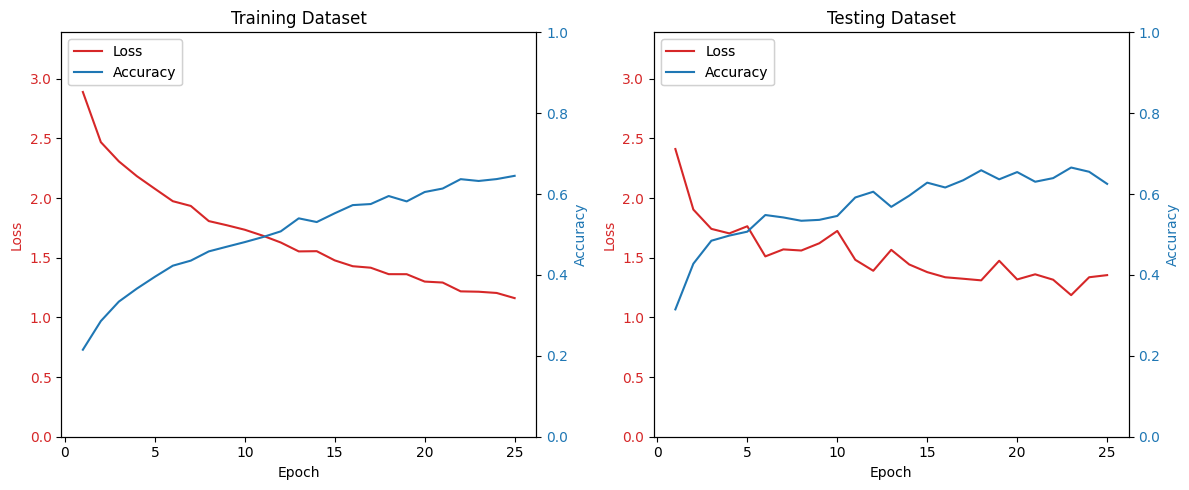

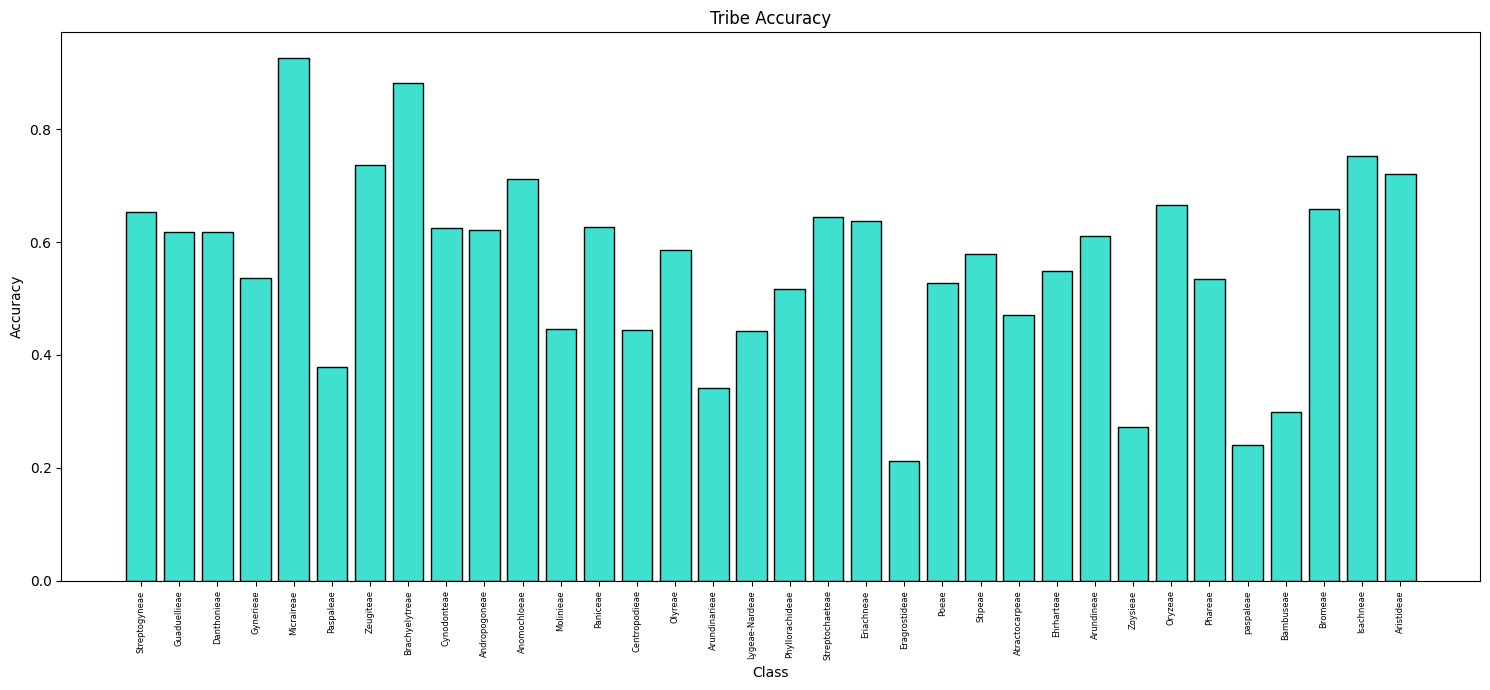

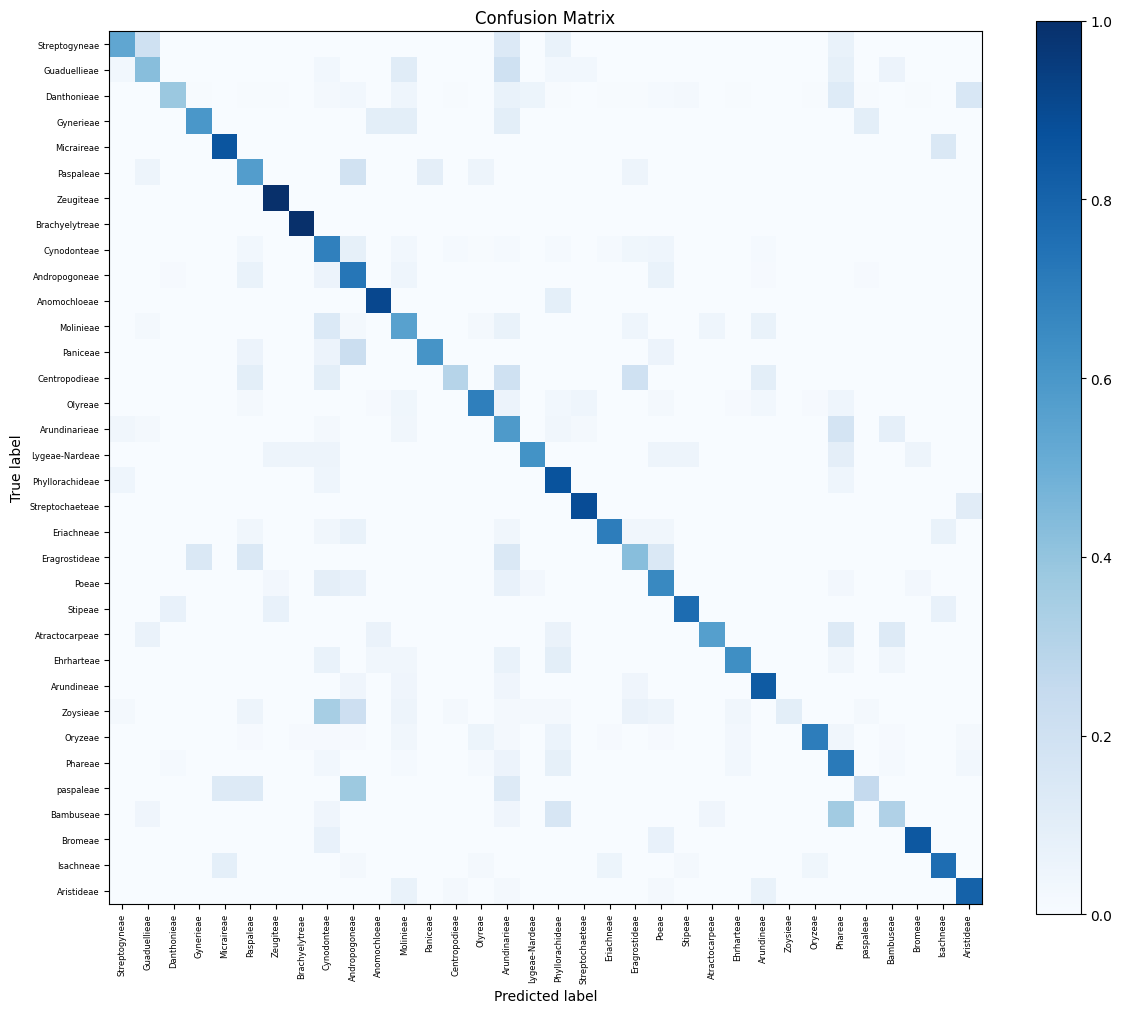

Model and results saved at: modelOutputTribe/trained_model.pt


In [9]:
# Run model for 25 epochs

model_save_path = train_model_with_outputs(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, save_dir='modelOutputTribe')
print(f'Model and results saved at: {model_save_path}')

In [11]:
# Display model architecture

summary(model_ft)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [ ]:
# Run this code to output examples of image classification

visualize_model(model_ft)